# Case study: Synthetic avalanche

In [15]:
import os
# Fix for OpenMP library conflicts on macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from skimage.metrics import structural_similarity as ssim_fn
from psimpy.sampler.latin import LHS
from psimpy.emulator import PPGaSP, PCAPPGaSP
from psimpy.emulator import OutputDimReducer, LinearPCA
from psimpy.utility import reduced_dim
from gpytorch_emulator import BiGP, PCA_BiGP, MultiTaskGP
from utils.error_metrics import ErrorMetrics
from utils.plot import _reconstruct_output_image, viz_prediction, viz_residuals, viz_output_image, viz_diff_grid_points, viz_all_2d_maps_in_one_plot, plot_pca_zero_output_hist
from utils.preprocess import zero_truncated_data

In [14]:
def per_run_ssim(gt, pred):
    scores = []
    scores = [ssim_fn(gt[i], pred[i], data_range=float(gt[i].max()-gt[i].min()))
          for i in range(len(gt))]
    return scores

def mean_behavior_ssim(gt_mean, pred_mean):
    ssim_score, ssim_map = ssim_fn(gt_mean, pred_mean, data_range=float(gt_mean.max()-gt_mean.min()), full=True)
    return ssim_score, ssim_map

## Data setup

In [2]:
# Get the root directory of the repository
def get_repo_root() -> Path:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
    return Path(root.decode().strip())

DATA_PATH = get_repo_root() / "data"
QOI = "hmax"
THRESHOLD = 0.5

In [3]:
def load_dataset(input_filepath, output_filepath, valid_columns=None, threshold: float = 0.5):
    input_data = np.genfromtxt(input_filepath, delimiter=',', skip_header=1)    
    output_data, valid_cols, rows, cols = zero_truncated_data(output_filepath, threshold=threshold,  valid_cols=valid_columns) 
    return input_data, output_data, valid_cols, rows, cols

In [6]:
train_data_root_folder = os.path.join(DATA_PATH, "synthetic", "train")
test_data_root_folder = os.path.join(DATA_PATH, "synthetic", "test")
train_input_filepath = os.path.join(train_data_root_folder, "input", "synth_emulator.csv")
train_output_filepath = os.path.join(train_data_root_folder, "output", QOI + "_stack.tif") 
test_input_filepath = os.path.join(test_data_root_folder, "input", "synth_validation_emulator.csv")
test_output_filepath = os.path.join(test_data_root_folder, "output", QOI + "_stack.tif") 
hill_path = None
train_X, train_Y, valid_cols, rows, cols = load_dataset(train_input_filepath, train_output_filepath, threshold=THRESHOLD)
test_X, test_Y, _, _, _ = load_dataset(test_input_filepath, test_output_filepath, threshold=THRESHOLD, valid_columns=valid_cols)
output_img_params = {
                    "filtered_columns": valid_cols, 
                    "output_img_rows": rows, 
                    "output_img_cols": cols, 
                    "background_img_path": hill_path,
                    }
print(f"Train X shape: {train_X.shape}, Train Y shape: {train_Y.shape}")
print(f"Test X shape: {test_X.shape}, Test Y shape: {test_Y.shape}")

Train X shape: (100, 3), Train Y shape: (100, 7878)
Test X shape: (20, 3), Test Y shape: (20, 7878)


## GP variants
### (1) PPGaSP in RobustGaSP

In [ ]:
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])
    
# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

predictions_mean = predictions[:, :, 0]
predictions_lower = predictions[:, :, 1]
predictions_upper = predictions[:, :, 2]
predictions_std = predictions[:, :, 3]

The upper bounds of the range parameters are 8.138874 60882.27 41.93205 
The initial values of range parameters are 0.1627775 1217.645 0.838641 
Start of the optimization  1  : 
The number of iterations is  11 
 The value of the  marginal posterior  function is  -282125.5 
 Optimized range parameters are 0.09684473 1238.267 1.273809 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 0.07730886 578.3035 0.3983007 
Start of the optimization  2  : 
The number of iterations is  12 
 The value of the  marginal posterior  function is  -282125.5 
 Optimized range parameters are 0.09684473 1238.267 1.273809 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


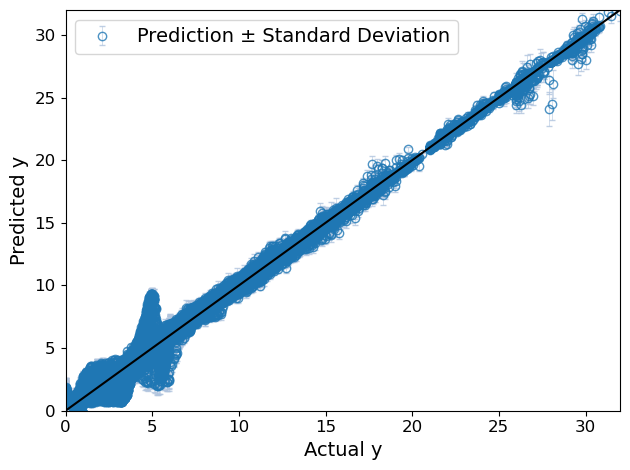

In [9]:
predictions = np.dstack((predictions_mean, predictions_std))
viz_prediction(test_Y, predictions, threshold=THRESHOLD)

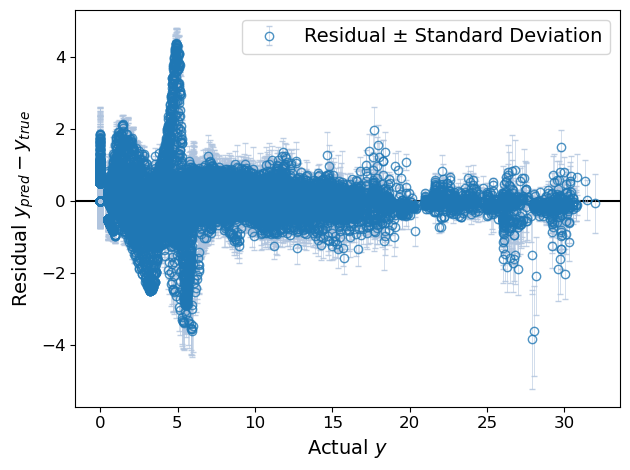

In [10]:
viz_residuals(test_Y, predictions, threshold=THRESHOLD)

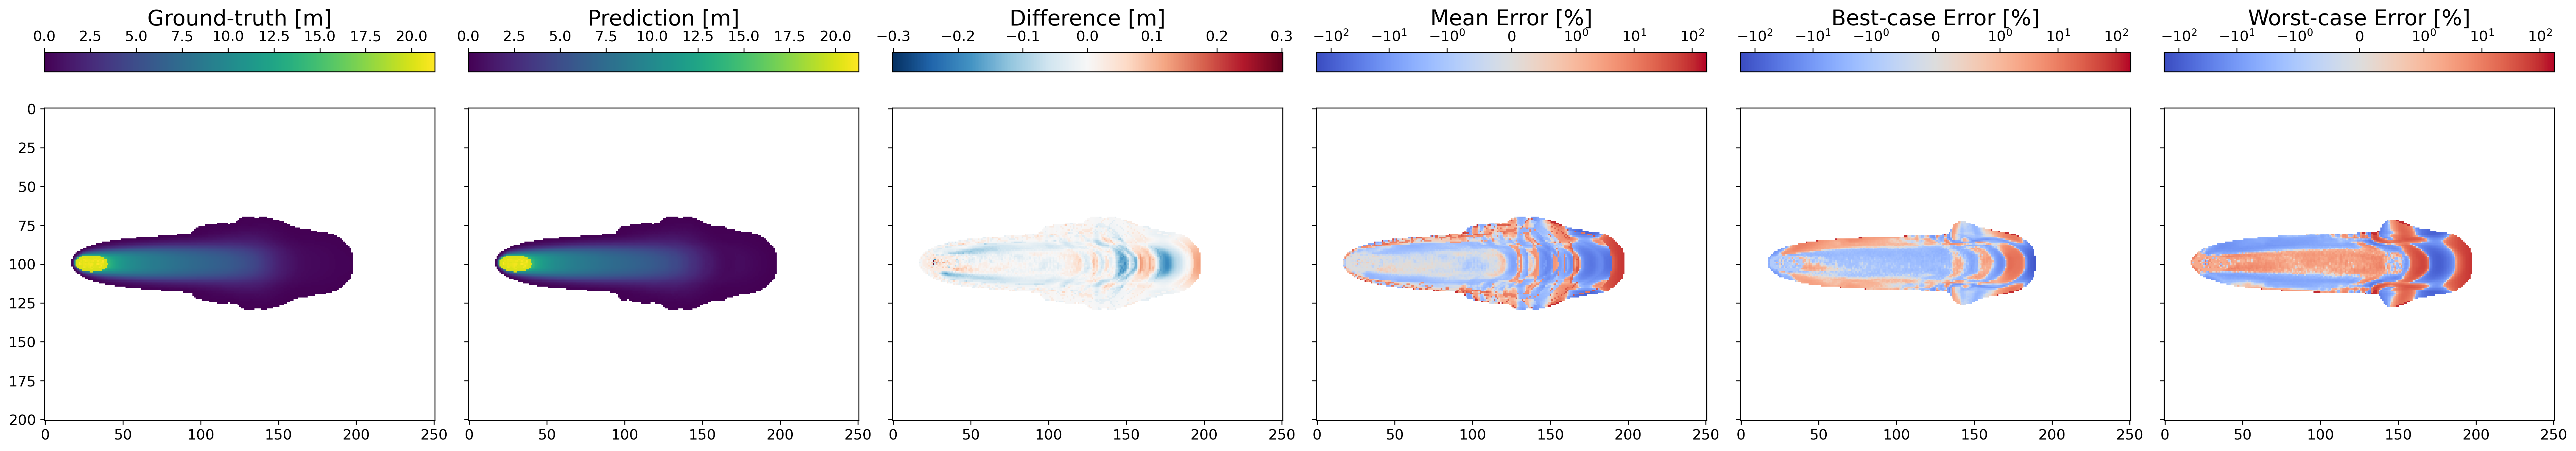

In [12]:
viz_all_2d_maps_in_one_plot(test_Y, predictions_mean, output_img_params, qoi="hmax", threshold=THRESHOLD)

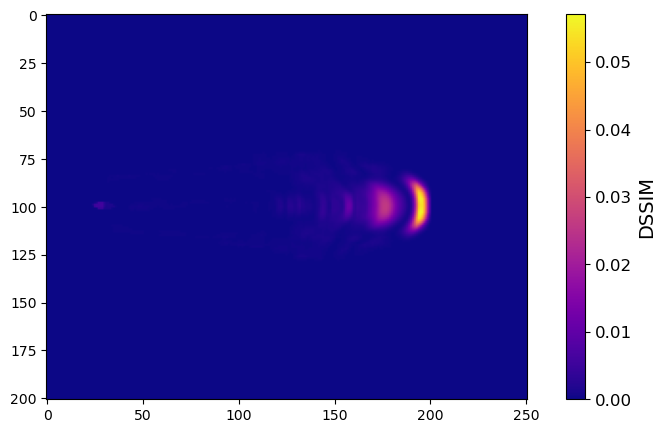

In [16]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(predictions_mean < THRESHOLD, 0.0, predictions_mean)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [17]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_mean)
predictions_lower = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_lower)
predictions_upper = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_upper)
predictions_std = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_std)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


ppgasp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {ppgasp_results["dssim"]: .3f}')

Training time: 2.583 s
Inference time: 0.015 s
RMSE:  0.174
95% confidence interval coverage probability:  0.843
Quantile coverage error:  0.107
DSSIM:  0.002


### (2) BiGP (PPGaSP in GPytorch)

In [ ]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = BiGP(device=device, kernel_type='matern_5_2')

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, num_epochs=200, lr=0.05, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

bigp_results = {
    "prediction_mean": mean,
    "prediction_std": std,
    "training_time": training_time,
    "infer_time": infer_time
}

training...:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/200, Loss: 1.729


training...:   5%|▌         | 10/200 [00:45<14:40,  4.63s/it]

Epoch 10/200, Loss: 1.566


training...:  10%|█         | 20/200 [01:29<12:57,  4.32s/it]

Epoch 20/200, Loss: 1.411


training...:  15%|█▌        | 30/200 [02:11<11:10,  3.95s/it]

Epoch 30/200, Loss: 1.252


training...:  20%|██        | 40/200 [02:56<11:47,  4.42s/it]

Epoch 40/200, Loss: 1.092


training...:  25%|██▌       | 50/200 [03:39<10:38,  4.25s/it]

Epoch 50/200, Loss: 0.947


training...:  30%|███       | 60/200 [04:31<13:57,  5.99s/it]

Epoch 60/200, Loss: 0.844


training...:  35%|███▌      | 70/200 [05:33<14:09,  6.53s/it]

Epoch 70/200, Loss: 0.783


training...:  40%|████      | 80/200 [06:56<17:58,  8.99s/it]

Epoch 80/200, Loss: 0.761


training...:  45%|████▌     | 90/200 [08:46<21:35, 11.78s/it]

Epoch 90/200, Loss: 0.760


training...:  50%|█████     | 100/200 [11:06<24:50, 14.90s/it]

Epoch 100/200, Loss: 0.773


training...:  52%|█████▏    | 103/200 [11:53<25:01, 15.48s/it]

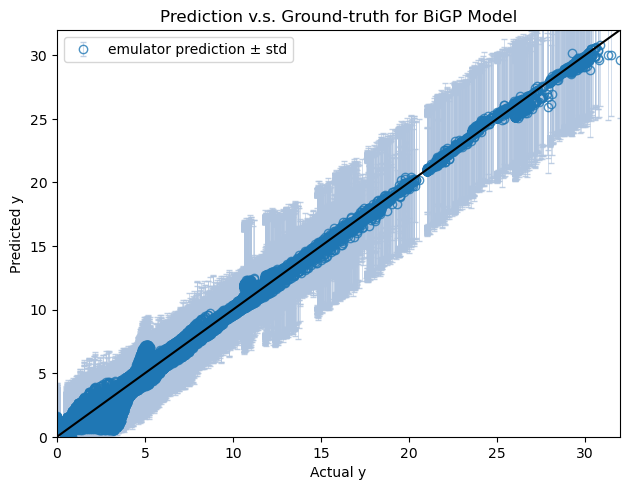

In [ ]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, threshold=THRESHOLD)

In [ ]:
viz_residuals(test_Y, preds, threshold=THRESHOLD)

In [ ]:
viz_all_2d_maps_in_one_plot(test_Y, mean, output_img_params, qoi="hmax", threshold=THRESHOLD)

In [ ]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(mean < THRESHOLD, 0.0, mean)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [ ]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean < THRESHOLD, 0, predictions_mean)
predictions_lower = np.where(lower < THRESHOLD, 0, predictions_lower)
predictions_upper = np.where(upper < THRESHOLD, 0, predictions_upper)
predictions_std = np.where(std < THRESHOLD, 0, predictions_std)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


bigp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {bigp_results["dssim"]: .3f}')

#### (3) MTGP (LMC)

In [ ]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = MultiTaskGP(base_inducing=64, min_rank=10, use_pca_init=True, device=device)

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, epochs=500, lr=0.1, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

In [ ]:
predictions = np.dstack((mean, std))
viz_prediction(test_Y, predictions, threshold=THRESHOLD)

In [ ]:
viz_residuals(test_Y, predictions, threshold=THRESHOLD)

In [ ]:
viz_all_2d_maps_in_one_plot(test_Y, mean, output_img_params, qoi="hmax", threshold=THRESHOLD)

In [ ]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(mean < THRESHOLD, 0.0, predictions_mean)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [ ]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean < THRESHOLD, 0, predictions_mean)
predictions_lower = np.where(lower < THRESHOLD, 0, predictions_lower)
predictions_upper = np.where(upper < THRESHOLD, 0, predictions_upper)
predictions_std = np.where(std < THRESHOLD, 0, predictions_std)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


lmc_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {lmc_results["dssim"]: .3f}')